# CAMeLBERT-mix

In [1]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
print("="*50)
print("GPU CHECK")
print("="*50)
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("WARNING: No GPU detected!")
    print("Go to Settings → Accelerator → Select 'GPU T4 x2'")
print("="*50)

GPU CHECK
CUDA available: True
Device count: 1
Current device: 0
Device name: Tesla P100-PCIE-16GB
CUDA version: 12.4


In [4]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from datasets import Dataset, load_dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    EarlyStoppingCallback
)

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    cohen_kappa_score, 
    classification_report,
    confusion_matrix, 
    ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt

E0000 00:00:1763313964.373682      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763313964.426631      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [5]:
MODEL_NAME = "CAMeL-Lab/bert-base-arabic-camelbert-mix"
path = "/kaggle/input/bayyin-dataset/bayyin_dataset.csv"

In [6]:
OUTPUT_DIR_WORD = "/kaggle/working/runs/CAMeLBERT-mix_Word"
OUTPUT_DIR_D3TOK = "/kaggle/working/runs/CAMeLBERT-mix_D3Tok"
OUTPUT_DIR_LEX = "/kaggle/working/runs/CAMeLBERT-mix_Lex"
OUTPUT_DIR_D3LEX = "/kaggle/working/runs/CAMeLBERT-mix_D3Lex"

SAVE_DIR_WORD = "/kaggle/working/CAMeLBERT-mix_Word"
SAVE_DIR_D3TOK = "/kaggle/working/CAMeLBERT-mix_D3Tok"
SAVE_DIR_LEX = "/kaggle/working/CAMeLBERT-mix_Lex"
SAVE_DIR_D3LEX = "/kaggle/working/CAMeLBERT-mix_D3Lex"

In [7]:
#Training parameters
LABEL_COL = "Readability_Level"
LEVELS = [1, 2, 3, 4, 5, 6]
LR = 3e-5
BATCH = 32
EPOCHS = 6
MAX_LEN = 128
SEED = 42
SOFT_BETA = 2.0

## Data Preparation

In [8]:
print("\nLoading dataset...")
dataset = load_dataset("csv", data_files={"train": path}, split="train")
print(f"Dataset columns: {dataset.column_names}")
print(f"Dataset size: {len(dataset)}")


Loading dataset...


Generating train split: 0 examples [00:00, ? examples/s]

Dataset columns: ['ID', 'Sentence', 'Word_Count', 'Word', 'Lex', 'D3Tok', 'D3Lex', 'Readability_Level', 'Document', 'Source', 'Book', 'Author', 'Domain', 'Text_Class', 'Dataset_Source']
Dataset size: 46410


In [9]:
required_columns = ["Word", "D3Tok", "Lex", "D3Lex", LABEL_COL]
missing = [col for col in required_columns if col not in dataset.column_names]
if missing:
    print(f"Missing columns: {missing}")

In [10]:
train_test = dataset.train_test_split(test_size=0.3, seed=SEED)
test_valid = train_test["test"].train_test_split(test_size=1/3, seed=SEED)
splits = DatasetDict({
    "train": train_test["train"],
    "test": test_valid["train"],
    "validation": test_valid["test"],
})
print(f"Train: {len(splits['train'])}, Test: {len(splits['test'])}, Val: {len(splits['validation'])}")

Train: 32487, Test: 9282, Val: 4641


In [11]:
level2id = {lvl: i for i, lvl in enumerate(LEVELS)}
id2level = {i: lvl for lvl, i in level2id.items()}

def map_labels(ds):
    return ds.map(lambda ex: {"labels": level2id[int(ex[LABEL_COL])]})

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Model Training

In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro")
    qwk = cohen_kappa_score(labels, preds, weights="quadratic")
    return {"accuracy": acc, "macro_f1": macro_f1, "qwk": qwk}

In [13]:
class SoftLabelsLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        K = logits.shape[-1]

        indices = torch.arange(K).float().to(logits.device)
        labels_float = labels.float().unsqueeze(1)
        diff = indices - labels_float
        squared_diff_normalized = (diff / SOFT_BETA) ** 2
        soft_targets = torch.exp(-0.5 * squared_diff_normalized)
        soft_targets = soft_targets / soft_targets.sum(dim=1, keepdim=True)

        log_softmax_logits = F.log_softmax(logits, dim=-1)
        loss_fct = nn.KLDivLoss(reduction='batchmean')
        loss = loss_fct(log_softmax_logits, soft_targets)

        return (loss, outputs) if return_outputs else loss

In [14]:
def eval_and_report(ds, name, trainer_obj):
    out = trainer_obj.predict(ds)
    preds = out.predictions.argmax(-1)
    print(f"\n{'='*60}")
    print(f"{name} Metrics")
    print('='*60)
    print(out.metrics)
    y_true = ds["labels"]
    target_names = [f"L{lvl}" for lvl in LEVELS]
    print("\nPer-class F1:")
    print(classification_report(y_true, preds, target_names=target_names, digits=4))

In [15]:
def plot_confusion_matrix_normalized(ds, trainer_obj, title_suffix="", normalize='true', cmap='Blues'):
    preds_output = trainer_obj.predict(ds)
    y_true = ds["labels"]
    y_pred = preds_output.predictions.argmax(-1)
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"L{lvl}" for lvl in LEVELS])
    fig, ax = plt.subplots(figsize=(7, 6))
    disp.plot(cmap=cmap, values_format=".2f", ax=ax, colorbar=True)
    plt.title(f"Normalized Confusion Matrix - {title_suffix}")
    plt.tight_layout()
    plt.show()

In [16]:
def train_model(text_col, output_dir, save_dir, model_name="Model"):
    print(f"\n{'#'*60}")
    print(f"# TRAINING MODEL: {model_name}")
    print(f"# Text Column: {text_col}")
    print(f"{'#'*60}\n")

    def tokenize_fn(batch):
        return tokenizer(batch[text_col], truncation=True, padding="max_length", max_length=MAX_LEN)
    
    train_ds = map_labels(splits["train"]).map(tokenize_fn, batched=True)
    val_ds = map_labels(splits["validation"]).map(tokenize_fn, batched=True)
    test_ds = map_labels(splits["test"]).map(tokenize_fn, batched=True)

    cols = ["input_ids", "attention_mask", "labels"]
    train_ds.set_format(type="torch", columns=cols)
    val_ds.set_format(type="torch", columns=cols)
    test_ds.set_format(type="torch", columns=cols)

    print(f"Loading model: {MODEL_NAME}")
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(LEVELS))

    args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=LR,
        per_device_train_batch_size=BATCH,
        per_device_eval_batch_size=BATCH,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        warmup_ratio=0.1,
        load_best_model_at_end=True,
        metric_for_best_model="qwk",
        greater_is_better=True,
        seed=SEED,
        report_to="none",
        save_total_limit=3,
        save_safetensors=False,
        fp16=torch.cuda.is_available(),
    )

    trainer = SoftLabelsLossTrainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    print(f"Starting Training for CAMeLBERT-mix (Soft β={SOFT_BETA}) for {EPOCHS} epochs...")
    trainer.train()

    print(f"\nSaving fine-tuned model to: {save_dir}")
    trainer.model.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)
    print("Model and tokenizer saved successfully!")

    print("\nEvaluating on Test Set...")
    eval_and_report(test_ds, f"Test (CAMeLBERT-mix + SOFT - {model_name})", trainer)
    plot_confusion_matrix_normalized(test_ds, trainer, title_suffix=model_name)

    return trainer, test_ds

In [17]:
def print_summary(results):
    """Print a comparison summary of all models"""
    print("\n" + "="*80)
    print("FINAL RESULTS SUMMARY - ALL MODELS")
    print("="*80)
    print(f"{'Model':<15} {'Accuracy':<12} {'Macro F1':<12} {'QWK':<12}")
    print("-"*80)
    
    for model_name, metrics in results.items():
        acc = metrics.get('eval_accuracy', 0)
        f1 = metrics.get('eval_macro_f1', 0)
        qwk = metrics.get('eval_qwk', 0)
        print(f"{model_name:<15} {acc:<12.4f} {f1:<12.4f} {qwk:<12.4f}")
    
    print("="*80)
    
    # Find best model for each metric
    best_acc = max(results.items(), key=lambda x: x[1].get('eval_accuracy', 0))
    best_f1 = max(results.items(), key=lambda x: x[1].get('eval_macro_f1', 0))
    best_qwk = max(results.items(), key=lambda x: x[1].get('eval_qwk', 0))
    
    print(f"\nBest Accuracy: {best_acc[0]} ({best_acc[1].get('eval_accuracy', 0):.4f})")
    print(f"Best Macro F1: {best_f1[0]} ({best_f1[1].get('eval_macro_f1', 0):.4f})")
    print(f"Best QWK: {best_qwk[0]} ({best_qwk[1].get('eval_qwk', 0):.4f})")
    print("="*80)

STARTING TRAINING PIPELINE FOR 4 MODELS - CAMeLBERT-mix

############################################################
# TRAINING MODEL: Word
# Text Column: Word
############################################################



Map:   0%|          | 0/32487 [00:00<?, ? examples/s]

Map:   0%|          | 0/32487 [00:00<?, ? examples/s]

Map:   0%|          | 0/4641 [00:00<?, ? examples/s]

Map:   0%|          | 0/4641 [00:00<?, ? examples/s]

Map:   0%|          | 0/9282 [00:00<?, ? examples/s]

Map:   0%|          | 0/9282 [00:00<?, ? examples/s]

Loading model: CAMeL-Lab/bert-base-arabic-camelbert-mix


pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Training for CAMeLBERT-mix (Soft β=2.0) for 6 epochs...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Qwk
1,0.070900,0.047464,0.542771,0.542792,0.832226
2,0.038900,0.049025,0.579832,0.576930,0.829837
3,0.022300,0.047652,0.610429,0.611339,0.840088
4,0.013300,0.046637,0.604611,0.605719,0.850975
5,0.009000,0.049214,0.610213,0.612102,0.840676
6,0.006700,0.048294,0.619479,0.623249,0.846434



Saving fine-tuned model to: /kaggle/working/CAMeLBERT-mix_Word
Model and tokenizer saved successfully!

Evaluating on Test Set...



Test (CAMeLBERT-mix + SOFT - Word) Metrics
{'test_loss': 0.04522431641817093, 'test_accuracy': 0.6063348416289592, 'test_macro_f1': 0.6070158942228733, 'test_qwk': 0.8576108399415402, 'test_runtime': 32.0194, 'test_samples_per_second': 289.887, 'test_steps_per_second': 9.088}

Per-class F1:
              precision    recall  f1-score   support

          L1     0.8335    0.6458    0.7277      1550
          L2     0.5833    0.7122    0.6413      1529
          L3     0.5156    0.5508    0.5326      1556
          L4     0.4184    0.4005    0.4093      1523
          L5     0.5766    0.5483    0.5621      1585
          L6     0.7574    0.7810    0.7690      1539

    accuracy                         0.6063      9282
   macro avg     0.6141    0.6064    0.6070      9282
weighted avg     0.6144    0.6063    0.6071      9282



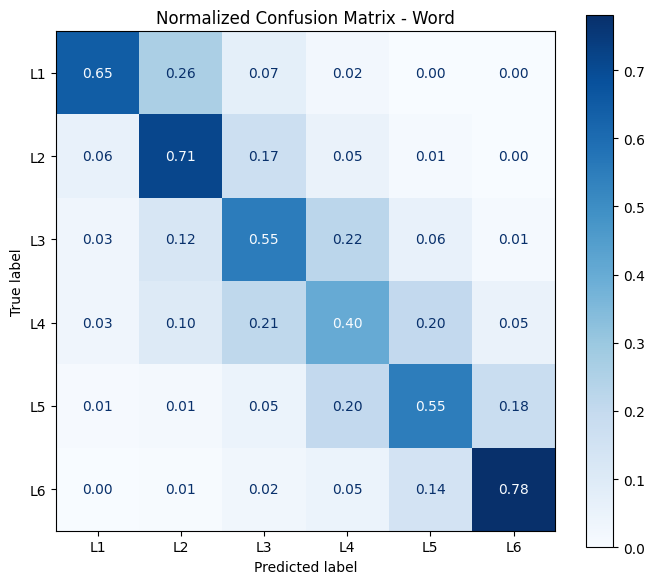


############################################################
# TRAINING MODEL: D3Tok
# Text Column: D3Tok
############################################################



Map:   0%|          | 0/32487 [00:00<?, ? examples/s]

Map:   0%|          | 0/4641 [00:00<?, ? examples/s]

Map:   0%|          | 0/9282 [00:00<?, ? examples/s]

Loading model: CAMeL-Lab/bert-base-arabic-camelbert-mix


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Training for CAMeLBERT-mix (Soft β=2.0) for 6 epochs...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Qwk
1,0.066900,0.044128,0.580263,0.575610,0.845382
2,0.036100,0.043634,0.624003,0.623590,0.849370
3,0.021800,0.040590,0.654816,0.653541,0.864677
4,0.013800,0.042434,0.659987,0.661954,0.866179
5,0.009400,0.043834,0.660849,0.662437,0.864563
6,0.007000,0.043082,0.655893,0.658948,0.865730



Saving fine-tuned model to: /kaggle/working/CAMeLBERT-mix_D3Tok
Model and tokenizer saved successfully!

Evaluating on Test Set...



Test (CAMeLBERT-mix + SOFT - D3Tok) Metrics
{'test_loss': 0.04109411686658859, 'test_accuracy': 0.6447963800904978, 'test_macro_f1': 0.6465845707898875, 'test_qwk': 0.8698533860758566, 'test_runtime': 32.089, 'test_samples_per_second': 289.258, 'test_steps_per_second': 9.069}

Per-class F1:
              precision    recall  f1-score   support

          L1     0.7788    0.7290    0.7531      1550
          L2     0.6304    0.6717    0.6504      1529
          L3     0.5113    0.5964    0.5506      1556
          L4     0.4324    0.4012    0.4162      1523
          L5     0.6333    0.6221    0.6276      1585
          L6     0.9195    0.8467    0.8816      1539

    accuracy                         0.6448      9282
   macro avg     0.6510    0.6445    0.6466      9282
weighted avg     0.6512    0.6448    0.6468      9282



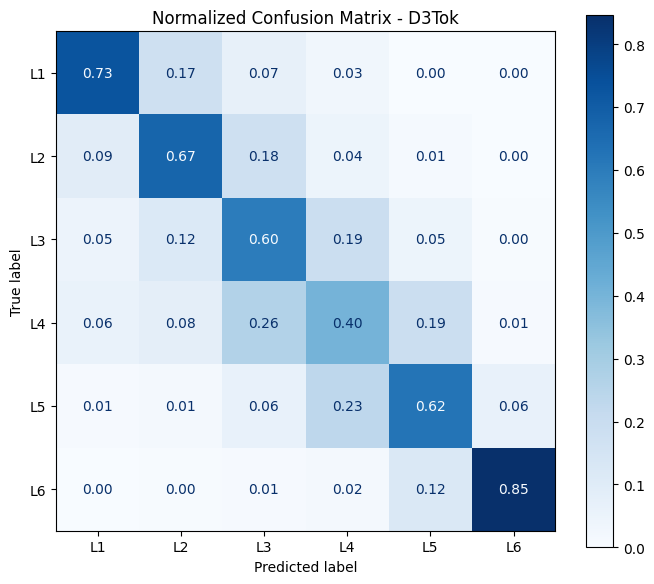


############################################################
# TRAINING MODEL: Lex
# Text Column: Lex
############################################################



Map:   0%|          | 0/32487 [00:00<?, ? examples/s]

Map:   0%|          | 0/4641 [00:00<?, ? examples/s]

Map:   0%|          | 0/9282 [00:00<?, ? examples/s]

Loading model: CAMeL-Lab/bert-base-arabic-camelbert-mix


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Training for CAMeLBERT-mix (Soft β=2.0) for 6 epochs...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Qwk
1,0.072400,0.050662,0.502478,0.498141,0.824311
2,0.042000,0.048829,0.560871,0.565040,0.829637
3,0.025600,0.050793,0.570351,0.571233,0.829580
4,0.016000,0.050588,0.584572,0.587375,0.840204
5,0.011000,0.052378,0.581340,0.582943,0.837248
6,0.008500,0.052357,0.577246,0.580959,0.833697



Saving fine-tuned model to: /kaggle/working/CAMeLBERT-mix_Lex
Model and tokenizer saved successfully!

Evaluating on Test Set...



Test (CAMeLBERT-mix + SOFT - Lex) Metrics
{'test_loss': 0.04848767817020416, 'test_accuracy': 0.5780004309416074, 'test_macro_f1': 0.5797398809767905, 'test_qwk': 0.8408896305435312, 'test_runtime': 31.9244, 'test_samples_per_second': 290.749, 'test_steps_per_second': 9.115}

Per-class F1:
              precision    recall  f1-score   support

          L1     0.6822    0.6535    0.6675      1550
          L2     0.5398    0.5945    0.5658      1529
          L3     0.5037    0.5636    0.5320      1556
          L4     0.3939    0.3756    0.3845      1523
          L5     0.5689    0.5653    0.5671      1585
          L6     0.8164    0.7135    0.7614      1539

    accuracy                         0.5780      9282
   macro avg     0.5841    0.5777    0.5797      9282
weighted avg     0.5844    0.5780    0.5800      9282



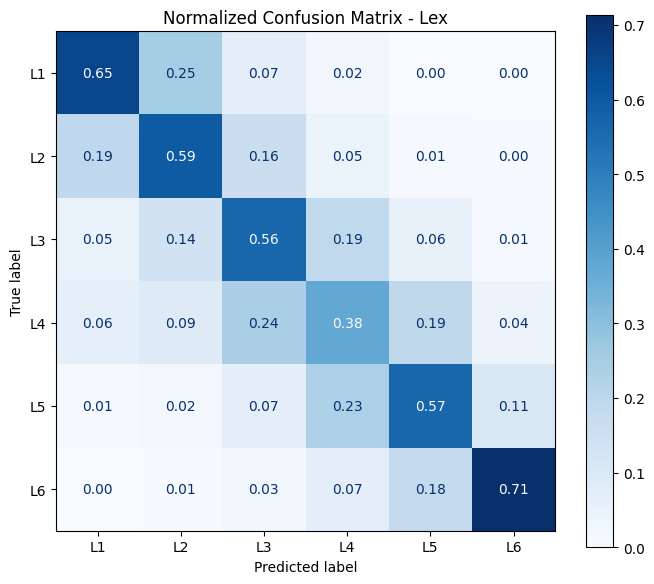


############################################################
# TRAINING MODEL: D3Lex
# Text Column: D3Lex
############################################################



Map:   0%|          | 0/32487 [00:00<?, ? examples/s]

Map:   0%|          | 0/4641 [00:00<?, ? examples/s]

Map:   0%|          | 0/9282 [00:00<?, ? examples/s]

Loading model: CAMeL-Lab/bert-base-arabic-camelbert-mix


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Training for CAMeLBERT-mix (Soft β=2.0) for 6 epochs...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Qwk
1,0.072700,0.049468,0.538462,0.535741,0.832008
2,0.042200,0.048798,0.593838,0.595086,0.832003
3,0.026100,0.048066,0.609351,0.610668,0.838396
4,0.016400,0.048871,0.608274,0.614695,0.839946
5,0.011400,0.051283,0.614954,0.616623,0.838016
6,0.008500,0.050808,0.619694,0.623211,0.839306



Saving fine-tuned model to: /kaggle/working/CAMeLBERT-mix_D3Lex
Model and tokenizer saved successfully!

Evaluating on Test Set...



Test (CAMeLBERT-mix + SOFT - D3Lex) Metrics
{'test_loss': 0.04707159101963043, 'test_accuracy': 0.5993320405085111, 'test_macro_f1': 0.6050049763280172, 'test_qwk': 0.8464198145461514, 'test_runtime': 31.9293, 'test_samples_per_second': 290.705, 'test_steps_per_second': 9.114}

Per-class F1:
              precision    recall  f1-score   support

          L1     0.7883    0.7013    0.7422      1550
          L2     0.6324    0.6527    0.6424      1529
          L3     0.4919    0.5431    0.5162      1556
          L4     0.3914    0.4071    0.3991      1523
          L5     0.5356    0.6177    0.5737      1585
          L6     0.8653    0.6719    0.7564      1539

    accuracy                         0.5993      9282
   macro avg     0.6175    0.5989    0.6050      9282
weighted avg     0.6174    0.5993    0.6052      9282



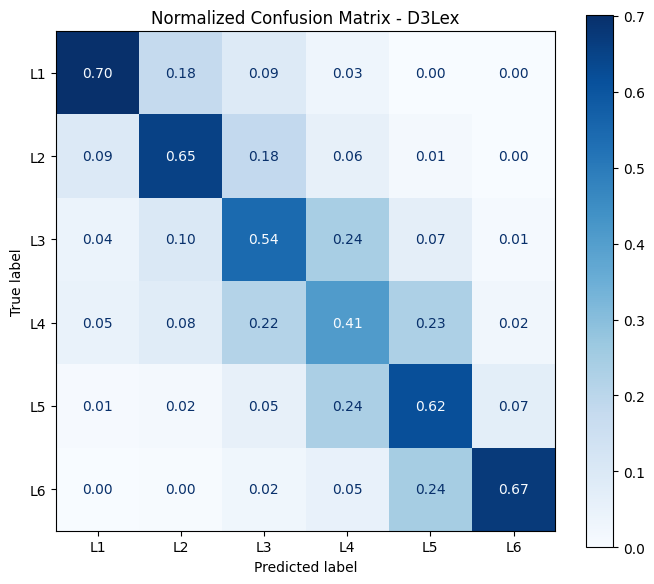


FINAL RESULTS SUMMARY - ALL MODELS
Model           Accuracy     Macro F1     QWK         
--------------------------------------------------------------------------------
Word            0.6063       0.6070       0.8576      
D3Tok           0.6448       0.6466       0.8699      
Lex             0.5780       0.5797       0.8409      
D3Lex           0.5993       0.6050       0.8464      

Best Accuracy: D3Tok (0.6448)
Best Macro F1: D3Tok (0.6466)
Best QWK: D3Tok (0.8699)

ALL TRAINING COMPLETE!

Models saved to:
  - /kaggle/working/CAMeLBERT-mix_Word
  - /kaggle/working/CAMeLBERT-mix_D3Tok
  - /kaggle/working/CAMeLBERT-mix_Lex
  - /kaggle/working/CAMeLBERT-mix_D3Lex


In [18]:
if __name__ == "__main__":
    results = {}
    print("STARTING TRAINING PIPELINE FOR 4 MODELS - CAMeLBERT-mix")

    # Train Word
    trainer_word, test_ds_word = train_model("Word", OUTPUT_DIR_WORD, SAVE_DIR_WORD, "Word")
    results["Word"] = trainer_word.evaluate(test_ds_word)

    # Train D3Tok
    trainer_d3tok, test_ds_d3tok = train_model("D3Tok", OUTPUT_DIR_D3TOK, SAVE_DIR_D3TOK, "D3Tok")
    results["D3Tok"] = trainer_d3tok.evaluate(test_ds_d3tok)

    # Train Lex
    trainer_lex, test_ds_lex = train_model("Lex", OUTPUT_DIR_LEX, SAVE_DIR_LEX, "Lex")
    results["Lex"] = trainer_lex.evaluate(test_ds_lex)

    # Train D3Lex
    trainer_d3lex, test_ds_d3lex = train_model("D3Lex", OUTPUT_DIR_D3LEX, SAVE_DIR_D3LEX, "D3Lex")
    results["D3Lex"] = trainer_d3lex.evaluate(test_ds_d3lex)

    # Summary
    print_summary(results)
    print("\n" + "="*80)
    print("ALL TRAINING COMPLETE!")
    print("="*80)
    print(f"\nModels saved to:\n  - {SAVE_DIR_WORD}\n  - {SAVE_DIR_D3TOK}\n  - {SAVE_DIR_LEX}\n  - {SAVE_DIR_D3LEX}")
    print("="*80)